In [1]:
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM, Input, Dropout
from keras.layers import Dense
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from keras.models import Model
import seaborn as sns


/home/karim/.local/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Start date is:  2011-01-03 00:00:00
End date is:  2021-09-08 00:00:00


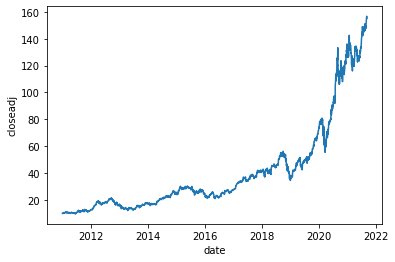

In [2]:
    
dataframe = pd.read_csv('../lstm/data/AAPL.csv')
df = dataframe[['date', 'closeadj']]
df['date'] = pd.to_datetime(df['date'])

sns.lineplot(x=df['date'], y=df['closeadj'])


print("Start date is: ", df['date'].min())
print("End date is: ", df['date'].max())

In [3]:
#Change train data from Mid 2017 to 2019.... seems to be a jump early 2017
train, test = df.loc[df['date'] <= '2019-12-31'], df.loc[df['date'] > '2019-12-31']

In [4]:
scaler = StandardScaler()
scaler = scaler.fit(train[['closeadj']])

train['closeadj'] = scaler.transform(train[['closeadj']])
test['closeadj'] = scaler.transform(test[['closeadj']])

/home/karim/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/home/karim/.local/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [5]:

seq_size = 14  # Number of time steps to look back 
#Larger sequences (look further back) may improve forecasting.


def to_sequences(x, y, seq_size=1):
    x_values = []
    y_values = []

    for i in range(len(x)-seq_size):
        #print(i)
        x_values.append(x.iloc[i:(i+seq_size)].values)
        y_values.append(y.iloc[i+seq_size])
        
    return np.array(x_values), np.array(y_values)

trainX, trainY = to_sequences(train[['closeadj']], train['closeadj'], seq_size)
testX, testY = to_sequences(test[['closeadj']], test['closeadj'], seq_size)

In [6]:

# define Autoencoder model
#Input shape would be seq_size, 1 - 1 beacuse we have 1 feature. 
# seq_size = trainX.shape[1]

model = Sequential()
model.add(LSTM(128, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
model.add(LSTM(64, activation='relu', return_sequences=False))
model.add(RepeatVector(trainX.shape[1]))
model.add(LSTM(64, activation='relu', return_sequences=True))
model.add(LSTM(128, activation='relu', return_sequences=True))
model.add(TimeDistributed(Dense(trainX.shape[2])))

model.compile(optimizer='adam', loss='mse')
model.summary()

#Try another model
# model = Sequential()
# model.add(LSTM(128, input_shape=(trainX.shape[1], trainX.shape[2])))
# model.add(Dropout(rate=0.2))

# model.add(RepeatVector(trainX.shape[1]))

# model.add(LSTM(128, return_sequences=True))
# model.add(Dropout(rate=0.2))
# model.add(TimeDistributed(Dense(trainX.shape[2])))
# model.compile(optimizer='adam', loss='mae')
# model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 14, 128)           66560     
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                49408     
_________________________________________________________________
repeat_vector (RepeatVector) (None, 14, 64)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 14, 64)            33024     
_________________________________________________________________
lstm_3 (LSTM)                (None, 14, 128)           98816     
_________________________________________________________________
time_distributed (TimeDistri (None, 14, 1)             129       
Total params: 247,937
Trainable params: 247,937
Non-trainable params: 0
__________________________________________________

Epoch 1/100
64/64 [==============================] - 11s 91ms/step - loss: 0.2234 - val_loss: 0.3281
Epoch 2/100
64/64 [==============================] - 5s 83ms/step - loss: 0.0226 - val_loss: 0.2429
Epoch 3/100
64/64 [==============================] - 5s 83ms/step - loss: 0.0126 - val_loss: 0.0718
Epoch 4/100
64/64 [==============================] - 5s 85ms/step - loss: 0.0077 - val_loss: 0.1509
Epoch 5/100
64/64 [==============================] - 5s 85ms/step - loss: 0.0067 - val_loss: 0.0377
Epoch 6/100
64/64 [==============================] - 6s 86ms/step - loss: 0.0060 - val_loss: 0.0252
Epoch 7/100
64/64 [==============================] - 5s 83ms/step - loss: 0.0108 - val_loss: 0.0511
Epoch 8/100
64/64 [==============================] - 5s 85ms/step - loss: 0.0052 - val_loss: 0.0495
Epoch 9/100
64/64 [==============================] - 5s 85ms/step - loss: 0.0044 - val_loss: 0.0444
Epoch 10/100
64/64 [==============================] - 5s 84ms/step - loss: 0.0046 - val_loss: 0.052

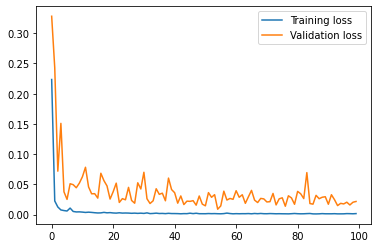

In [7]:

# fit model
history = model.fit(trainX, trainY, epochs=100, batch_size=32, validation_split=0.1, verbose=1)

plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

<AxesSubplot:xlabel='date', ylabel='testMAE'>

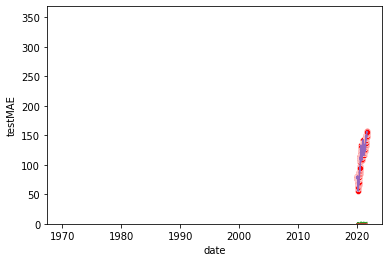

In [8]:

trainPredict = model.predict(trainX)
trainMAE = np.mean(np.abs(trainPredict - trainX), axis=1)
plt.hist(trainMAE, bins=30)
max_trainMAE = 0.3  #or Define 90% value of max as threshold.

testPredict = model.predict(testX)
testMAE = np.mean(np.abs(testPredict - testX), axis=1)
plt.hist(testMAE, bins=30)

#Capture all details in a DataFrame for easy plotting
anomaly_df = pd.DataFrame(test[seq_size:])
anomaly_df['testMAE'] = testMAE
anomaly_df['max_trainMAE'] = max_trainMAE
anomaly_df['anomaly'] = anomaly_df['testMAE'] > anomaly_df['max_trainMAE']
anomaly_df['closeadj'] = test[seq_size:]['closeadj']

#Plot testMAE vs max_trainMAE
sns.lineplot(x=anomaly_df['date'], y=anomaly_df['testMAE'])
sns.lineplot(x=anomaly_df['date'], y=anomaly_df['max_trainMAE'])

anomalies = anomaly_df.loc[anomaly_df['anomaly'] == True]

#Plot anomalies
sns.lineplot(x=anomaly_df['date'], y=scaler.inverse_transform(anomaly_df['closeadj']))
sns.scatterplot(x=anomalies['date'], y=scaler.inverse_transform(anomalies['closeadj']), color='r')